In [19]:
import matplotlib.pyplot as plt
import xarray as xr
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import matplotlib as mpl
from scipy.interpolate import griddata 
import warnings
import os
import datetime as dt
import numpy as np
sys.path.append('C:/Users/shjo/Bridge/JNUpack/mySO_src/libs/')
warnings.filterwarnings('ignore')
from myTools import myInfo
from myTrend import myfitting2d_sttcs,myRegress3d_sttcs
from myPlot import  figmaster,myClrbr, dta_colr
import matplotlib as mpl
# mpl.use('agg')

### ======================================================================
pthMO='J:/tmp_proc/Models/'
pthrn='J:/tmp_proc/Obs/'

varnm='OHC700'
myindx='SAM'

t_rng=['1993-01', '2017-12']
lat_rng=[-80,-30]; lon_rng=[0,360]

wpth='C:/Users/shjo/OneDrive/mySO/Regression_H/WCssn/'+myindx+'/'
mySig_npth='C:/Users/shjo/OneDrive/mySO/mySignals/my'+myindx+'.pkl'

### Preparation ============================================================
wpth=wpth+'WCssn_'+varnm+'_'+str(t_rng[0][:4])+'_'+str(t_rng[-1][:4])+'_'+\
    str(lat_rng[0])+'S'+str(lat_rng[-1])+'S'+'_'+\
        'E'+str(lon_rng[-1])+'E/'
wpth=wpth.replace('-','')
# try :
#     os.mkdir(wpth)
# except:
#     pass
# loc=sys._getframe().f_code.co_filename
# myInfo(loc,wpth)

myRnly=[pthrn+i for i in os.listdir(pthrn) if i.endswith('.nc')]
myMDOB=[pthMO+i for i in os.listdir(pthMO) if i.endswith('.nc')]
myDATA=myMDOB+myRnly
if int(t_rng[0].split('-')[0])<1992:
    myDATA=[i for i in myDATA if not i.split('/')[-1].startswith('myECCO')]
myDATA=[i for i in myDATA if not i.split('/')[-1].startswith('myISA')]

### load Index ==================================================================
with open(mySig_npth, 'rb') as f:
    data = pickle.load(f)
myIdx=data.loc['1993-01':'2017-12']

myIdx=(myIdx-myIdx.mean())/myIdx.std()

print('!!! Index --> Normalized !!!')

# print(mySAM)

myIdx_Cld=myIdx[ (myIdx.index.month==3)|(myIdx.index.month==4)|(myIdx.index.month==5)|\
    (myIdx.index.month==6)|(myIdx.index.month==7)|(myIdx.index.month==8)].resample('1Y').mean().values.reshape(-1)
myIdx_Wrm=myIdx[ (myIdx.index.month==10)|(myIdx.index.month==11)|(myIdx.index.month==12)|\
    (myIdx.index.month==1)|(myIdx.index.month==2)][2:]
myIdx_Wrm=np.array([myIdx_Wrm[myindx][5*n:5*n+5].mean() for n in range(int(len(myIdx_Wrm)/5))])

### Read Data ==============================================================
for i in myDATA: 
    print('!!! Open: '+i+' !!!')
    tmp=xr.open_dataset(i)
    mydata = tmp[varnm].loc[dict(lat=slice(lat_rng[0],lat_rng[-1])\
        ,time=slice(t_rng[0],t_rng[-1]))]
  
    mydata=mydata.where(mydata<10**20)
    mydata=mydata.where(mydata>-10**20)
    
    mydata=mydata.fillna(0)
    
    lonR,latR=mydata.lon.values,mydata.lat.values
    lonR_m,latR_m=np.meshgrid(lonR,latR)
    time=mydata.time.values
    dta_nm=i.split('/')[-1][2:-3].split('_')[0]+' '+varnm+' regression ('+myindx+')\n'+\
        'QQQ'+str(lon_rng[0])+'~'+str(lon_rng[-1])+'E '+str(time[0])[:4]+' '+str(time[-1])[:4]
    dta_snm=i.split('/')[-1][2:-3].split('_')[0]+' '+varnm+' regression '+myindx+'_'+\
        str(lat_rng[0])+'S'+str(lat_rng[-1])+'S'+' '+str(lon_rng[0])+'E'+str(lon_rng[-1])+'E_'+\
            str(time[0])[:4]+' '+str(time[-1])[:4]
    
    dta_snm=dta_snm.replace(' ','_').replace('salt','salinity').replace('-','')
    dta_nm=dta_nm.replace('salt','salinity').replace('-','')
    
    # mydata.time.dt.month==
    Cld_ssn_=mydata.loc[ (mydata.time.dt.month==3)|(mydata.time.dt.month==4)|(mydata.time.dt.month==5)|\
        (mydata.time.dt.month==6)|(mydata.time.dt.month==7)|(mydata.time.dt.month==8)]
    # mydata.time.dt.month==
    Wrm_ssn_=mydata.loc[ (mydata.time.dt.month==10)|(mydata.time.dt.month==11)|(mydata.time.dt.month==12)|\
        (mydata.time.dt.month==1)|(mydata.time.dt.month==2)][2:]

    Wrm_ssn=Wrm_ssn_[5*0:5*0+5].mean(dim='time')
    for n in range(1,int(len(Wrm_ssn_)/5)):
        Wrm_ssn=xr.concat([Wrm_ssn_[5*n:5*n+5].mean(dim='time',keepdims=True),Wrm_ssn],dim='time')
    # myIdx_Cld=np.array([myIdx_Cld['SAM'][5*n:5*n+5].mean() for n in range(int(len(myIdx_Cld)/5))])

    # Wrm_ssn=Wrm_ssn_.groupby('time.year').mean()
    Cld_ssn=Cld_ssn_.groupby('time.year').mean()


    # Linear regressiong
    slope_Wrm,intercept_Wrm,r_value_Wrm,p_value_Wrm,std_err_Wrm,smask_Wrm=\
        myRegress3d_sttcs(myIdx_Wrm,Wrm_ssn,threshold=0.05)
    slope_Cld,intercept_Cld,r_value_Cld,p_value_Cld,std_err_Cld,smask_Cld=\
        myRegress3d_sttcs(myIdx_Cld,Cld_ssn,threshold=0.05)
    
    smask_Wrm[slope_Wrm==0]=np.nan
    smask_Cld[slope_Cld==0]=np.nan
    raise
    # Figure
    myN=16
    mylim=[-.2,.2]
    CMAP,mylevel=myClrbr('myblc2',mylim,myN)
    CMAP_salt,mylevel_salt=myClrbr('salt',mylim,myN)
    CMAP_temp,mylevel_temp=myClrbr('balance',mylim,myN)

    slope_Wrm[slope_Wrm<mylim[0]]=mylim[0]
    slope_Wrm[slope_Wrm>mylim[-1]]=mylim[-1]
    
    slope_Cld[slope_Cld<mylim[0]]=mylim[0]
    slope_Cld[slope_Cld>mylim[-1]]=mylim[-1]
    
    mySetting={
        'figsize': '',
        'mylabel': '',
        'Label_size':18,
        'title_loc':'right',
        'fontParams':'Arial',
        'wpth':wpth}
    
    lat_rng_,lon_rng_=[-60,-53],[200,250]

    F=figmaster(mySetting)
    F.myCrtpy_sph4_box(latR_m,lonR_m,slope_Wrm/(10**9),smask_Wrm,CMAP,mylevel,dta_nm.replace('QQQ','Wrm '),\
        'Wrm_'+dta_snm,lat_rng_,lon_rng_)
    F.myCrtpy_sph4_box(latR_m,lonR_m,slope_Cld,smask_Cld/(10**9),CMAP,mylevel,dta_nm.replace('QQQ','Cld '),\
        'Cld_'+dta_snm,lat_rng_,lon_rng_)



!!! Index --> Normalized !!!
!!! Open: J:/tmp_proc/Models/myECCO_199201_201712_tsh.nc !!!


RuntimeError: No active exception to reraise

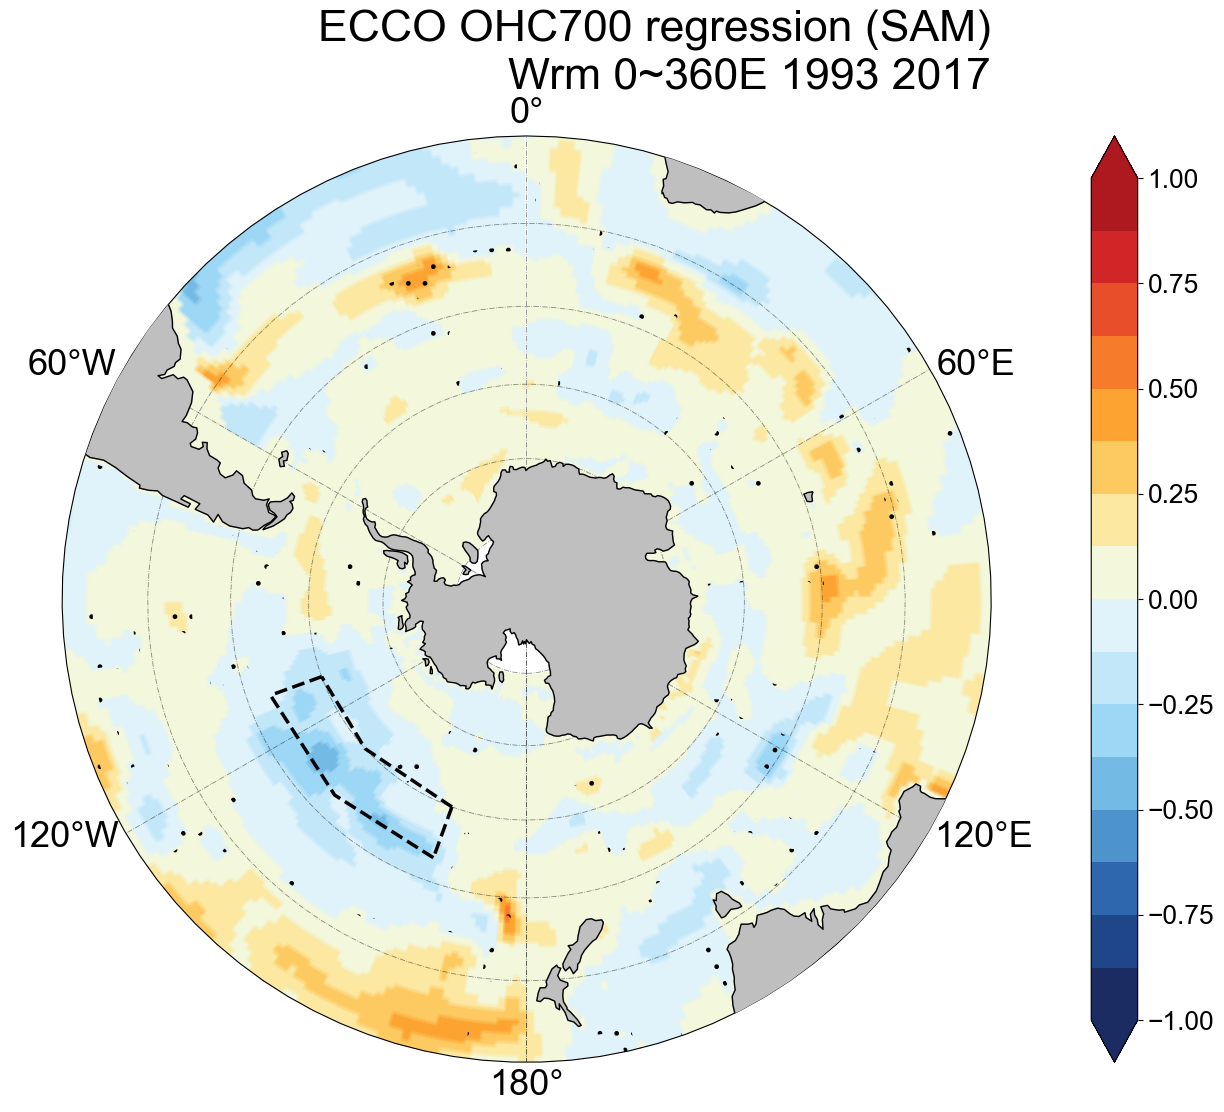

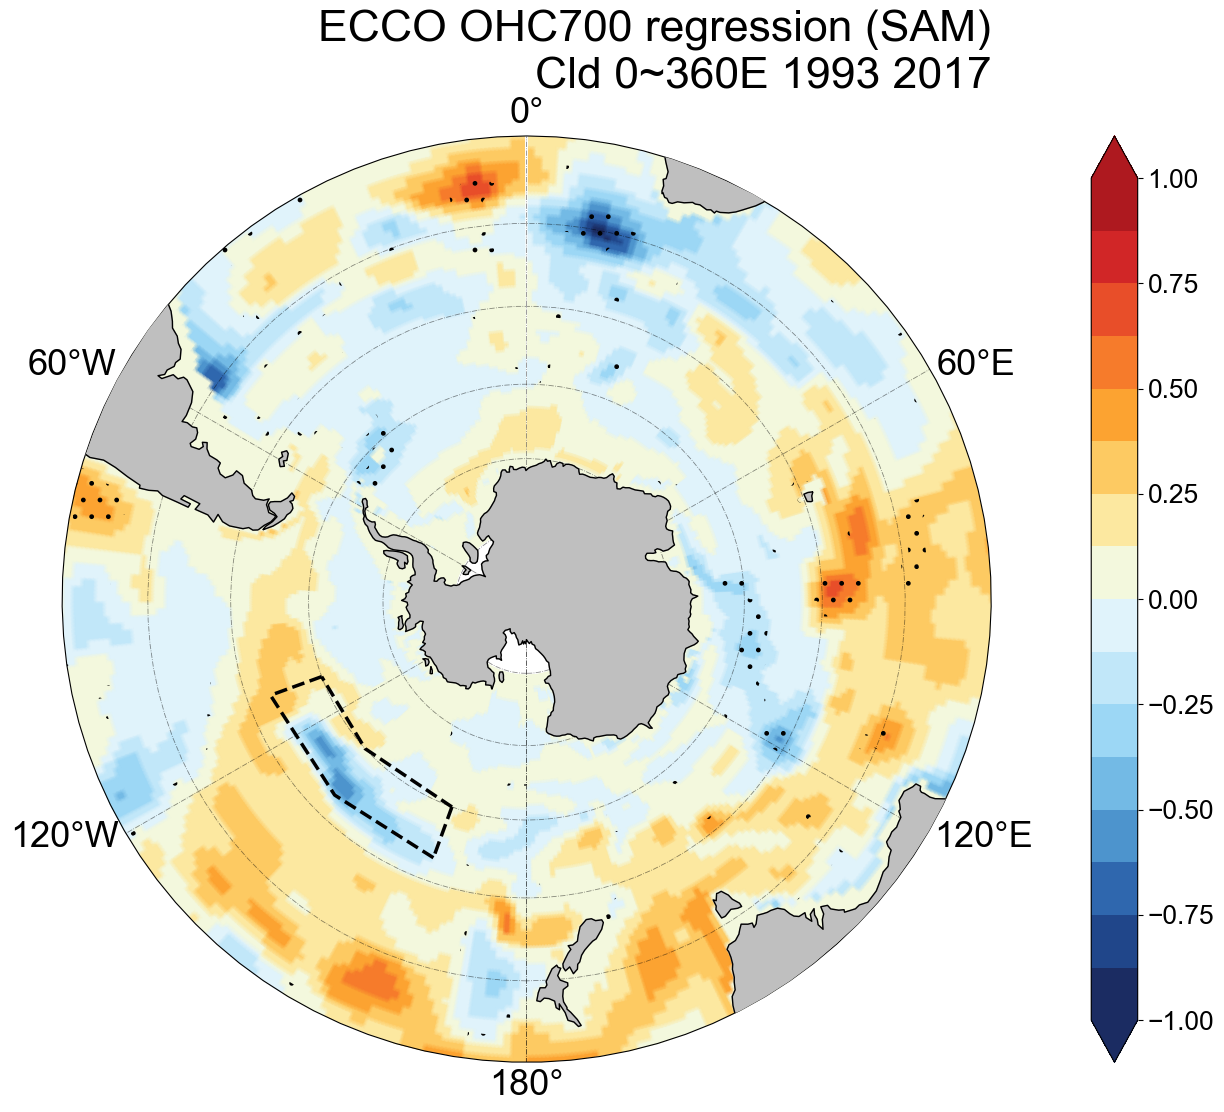

In [34]:
myN=16
mylim=[-1,1]
CMAP,mylevel=myClrbr('myblc2',mylim,myN)
CMAP_salt,mylevel_salt=myClrbr('salt',mylim,myN)
CMAP_temp,mylevel_temp=myClrbr('balance',mylim,myN)

# slope_Wrm[slope_Wrm<mylim[0]]=mylim[0]
# slope_Wrm[slope_Wrm>mylim[-1]]=mylim[-1]

# slope_Cld[slope_Cld<mylim[0]]=mylim[0]
# slope_Cld[slope_Cld>mylim[-1]]=mylim[-1]

mySetting={
    'figsize': '',
    'mylabel': '',
    'Label_size':18,
    'title_loc':'right',
    'fontParams':'Arial',
    'wpth':wpth}

lat_rng_,lon_rng_=[-60,-53],[200,250]

F=figmaster(mySetting)
F.myCrtpy_sph4_box(latR_m,lonR_m,slope_Wrm*10**-9,smask_Wrm,CMAP,mylevel,dta_nm.replace('QQQ','Wrm '),\
    'Wrm_'+dta_snm,lat_rng_,lon_rng_)
F.myCrtpy_sph4_box(latR_m,lonR_m,slope_Cld*10**-9,smask_Cld,CMAP,mylevel,dta_nm.replace('QQQ','Cld '),\
    'Cld_'+dta_snm,lat_rng_,lon_rng_)

In [23]:
np.min(slope_Cld/(10**9))

-0.9116959905895196

In [28]:
np.max(slope_Cld/(10**9))

0.721270614012979

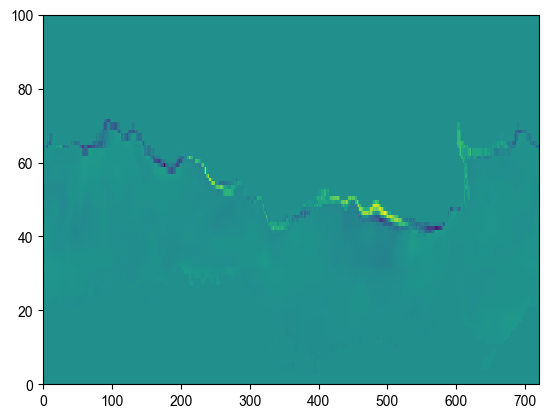

In [18]:
plt.pcolor(slope_Wrm)